## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [2]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True)

In [4]:
m

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [5]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [7]:
learn = ConvLearner.from_model_data(m, data)

In [8]:
learn.freeze_to(-4)

In [9]:
m[-1].trainable

True

In [10]:
m[-4].trainable

True

In [11]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch:   0, train_loss: 0.190022, val_loss: 0.000000, accuracy: 1.000000



In [12]:
learn.fit(0.01, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.123130, val_loss: 0.000000, accuracy: 1.000000
epoch:   1, train_loss: 0.078998, val_loss: 0.000000, accuracy: 1.000000
epoch:   2, train_loss: 0.102487, val_loss: 0.000000, accuracy: 1.000000



## CAM

In [13]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [14]:
x,y = next(iter(data.val_dl))
x,y = x[None,1], y[None,1]

vx = Variable(x.cuda(), requires_grad=True)

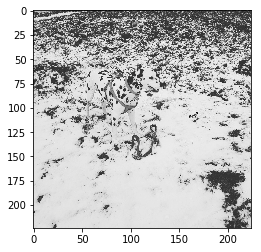

In [15]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [16]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([0., 1.], dtype=float32)

In [17]:
feat = np.maximum(0, sf.features[0])
feat.shape

(2, 7, 7)

In [18]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.12127, 0.29234, 0.21421, 0.11298, 0.09576, 0.08828, 0.     ],
       [0.56623, 0.86814, 0.74749, 0.55326, 0.54383, 0.53627, 0.29721],
       [0.57797, 0.84285, 0.79084, 0.63679, 0.69276, 0.67007, 0.41355],
       [0.41831, 0.58968, 0.57914, 0.51658, 0.62246, 0.55988, 0.29359],
       [0.4905 , 0.78739, 0.8697 , 0.81752, 0.87031, 0.67093, 0.30893],
       [0.47507, 0.76251, 0.89083, 0.90974, 1.     , 0.7746 , 0.38853],
       [0.27608, 0.52261, 0.66414, 0.70903, 0.79818, 0.58907, 0.24983]], dtype=float32)

/home/apil/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


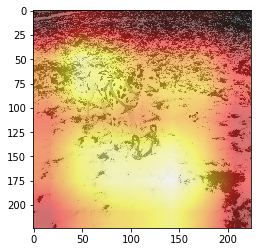

In [19]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lr=np.array([1e-6,1e-4,1e-2])

In [ ]:
learn.fit(lr, 2, cycle_len=1)

In [ ]:
accuracy(*learn.TTA())

In [ ]:
learn.fit(lr, 2, cycle_len=1)

In [ ]:
accuracy(*learn.TTA())